In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import sep

In [66]:
def extract_source(data):
    # Calculate background statistics
    data = data.astype(np.float32)

    bkg = sep.Background(data)
    signal = data - bkg
    sources = sep.extract(signal, 1.5, err=bkg.globalrms, minarea=40)
    return sources, signal

In [67]:
def plot_aperature(data, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(data)
    plt.imshow(roi_data, cmap='Greys', origin='lower')
    plt.colorbar(label='Intensity')
    plt.show()

In [68]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

APERTURE_R = 10

def calc_hfd(signal, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(signal)
    dist_weighted_flux = 0
    for (y, x), pix in np.ndenumerate(roi_data):
        dist = np.sqrt(y*y+x*x)
        if dist < APERTURE_R:
            dist_weighted_flux += pix * dist

    # total_flux = aperture_photometry(signal, aperture)['aperture_sum'][0]
    total_flux = np.sum(roi_data)
    return dist_weighted_flux / total_flux * 2

def calc_fwhm(signal, aperture):
    xycen = aperture.positions
    edge_radii = np.arange(25)
    rp = RadialProfile(signal, xycen, edge_radii, mask=None)
    fwhm_value = rp.gaussian_fwhm
    # plot_aperature(signal, rp.apertures[-1])
    return fwhm_value

In [69]:
# from glob import glob
base = "http://72.233.250.83/data/ecam/20231021/ecam"
# images = [f"{base}-00{i}.fits" for i in range(33,40)]
# # images = glob('focus_test/manual/*.fits')
# # images.sort()
# images

In [70]:
dp = {
    33: 3000,
    31: 0,
    32: 1500,
    34: 4500,
    36: 6000,
    37: -1500,
    38: -3000,
    39: -4500,
    40: -6000,
}

In [71]:
fwhm_curve_dp = []
hfd_curve_dp = []
focuser_positions = []


for (img_id, current_focus) in dp.items():
    print(img_id)
    img = f"{base}-00{img_id}.fits"
    hdul = fits.open(img)
    data = hdul[0].data
    # current_focus = hdul[0].header['FOCUSPOS']
    sources, signal = extract_source(data)

    x_coords = sources['x']
    y_coords = sources['y']
    x,y = list(zip(x_coords, y_coords))[0]

    # Calculate the FWHM for each detected star
    fwhm_values = []
    hfd_values = []

    for x, y in zip(x_coords, y_coords):
        aperture = CircularAperture((x, y), r=APERTURE_R)
        fwhm_value = calc_fwhm(signal, aperture)
        fwhm_values.append(fwhm_value)

        # HFD
        hfd = calc_hfd(signal, aperture)
        hfd_values.append(hfd)
    
    fwhm_values = np.array(fwhm_values)
    hfd_values = np.array(hfd_values)
    mean_fwhm = np.mean(fwhm_values)
    mean_hfd = np.mean(hfd_values)
    fwhm_curve_dp.append(mean_fwhm)
    hfd_curve_dp.append(mean_hfd)
    focuser_positions.append(current_focus)
    print(f'Focus: {current_focus} FWHM: {mean_fwhm} HFD: {mean_hfd}')


33
Focus: 3000 FWHM: 5.3984241283893795 HFD: 0.1862868526723464
31
Focus: 0 FWHM: 4.693866276406432 HFD: 0.25530916093950434
32
Focus: 1500 FWHM: 5.001645570361233 HFD: 0.17307995425196937
34
Focus: 4500 FWHM: 6.423743539021113 HFD: 0.5937330969250255
36
Focus: 6000 FWHM: 9.111733089390158 HFD: 0.3100014696564545
37
Focus: -1500 FWHM: 4.301254043956106 HFD: 0.06826273099563598
38
Focus: -3000 FWHM: 3.5162538361290387 HFD: 0.22818754608735933
39
Focus: -4500 FWHM: 3.6657812166098642 HFD: -0.1674028362002335
40
Focus: -6000 FWHM: 3.952133872257408 HFD: 0.49696797433050227


In [72]:
# fit the data with a quadratic
fwhm_fit = np.polyfit(focuser_positions, fwhm_curve_dp, 2)

# predict the minimum value
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])

print(f"FWHM predicted focuser position is {fwhm_min_value:.2f}")

# fit the data with a quadratic
hfd_fit = np.polyfit(focuser_positions, hfd_curve_dp, 2)

# predict the minimum value
hfd_min_value = -hfd_fit[1] / (2 * hfd_fit[0])

print(f"HFD predicted focuser position is {hfd_min_value:.2f}")


FWHM predicted focuser position is -3409.41
HFD predicted focuser position is -1377.15


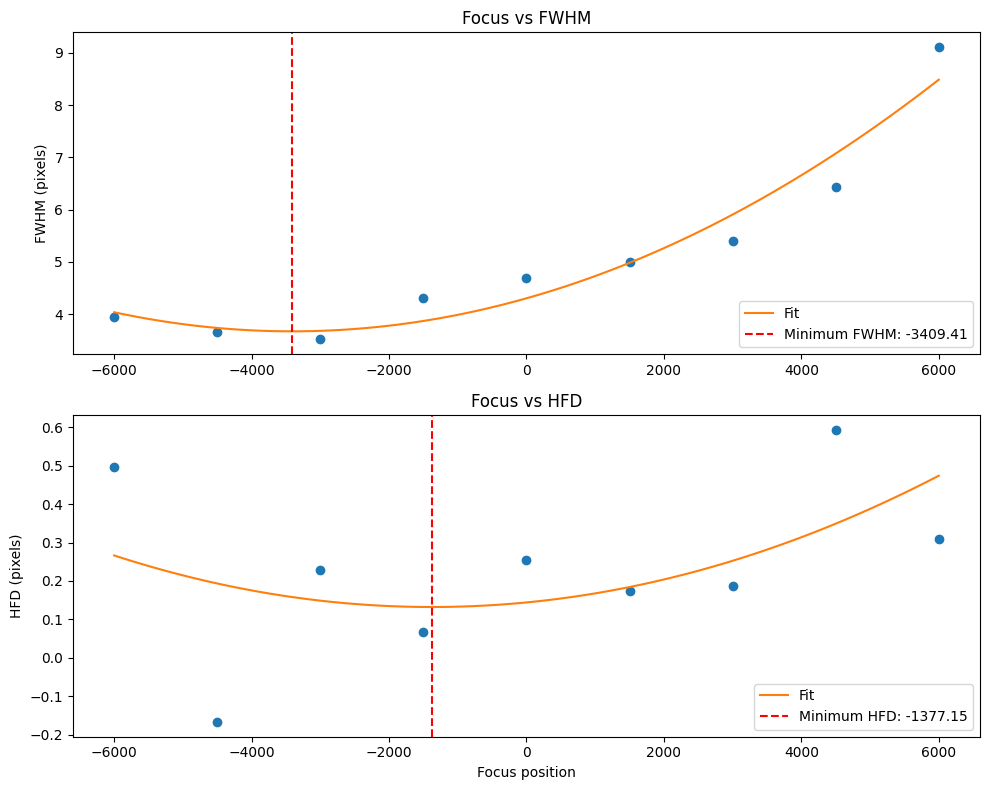

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

x_fit = np.linspace(min(focuser_positions), max(focuser_positions), 100)

# plot FWHM curve and fit
ax1.plot(focuser_positions, fwhm_curve_dp, 'o')
y_fit = np.polyval(fwhm_fit, x_fit)
ax1.plot(x_fit, y_fit, label='Fit')
ax1.set_ylabel('FWHM (pixels)')
ax1.set_title('Focus vs FWHM')

# plot HFD curve and fit
ax2.plot(focuser_positions, hfd_curve_dp, 'o')
y_fit = np.polyval(hfd_fit, x_fit)
ax2.plot(x_fit, y_fit, label='Fit')
ax2.set_xlabel('Focus position')
ax2.set_ylabel('HFD (pixels)')
ax2.set_title('Focus vs HFD')

# mark the minimum value of the fit
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])
ax1.axvline(fwhm_min_value, color='r', linestyle='--', label=f'Minimum FWHM: {fwhm_min_value:.2f}')

hfd_min_value = -hfd_fit[1] / (2 * hfd_fit[0])
ax2.axvline(hfd_min_value, color='r', linestyle='--', label=f'Minimum HFD: {hfd_min_value:.2f}')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
